In [4]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import cv2
import matplotlib.pyplot as plt

def display(img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1)
  plt.title('Zoomed LR', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title('ResShift', fontsize=16)
  ax2.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)
def imread(img_path):
  img = cv2.imread(img_path)
  if img.ndim > 3:
    img = img[:, :, :3]
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# Training

Downloading: "https://github.com/zsyOAOA/ResShift/releases/download/v2.0/resshift_realsrx4_s15_v1.pth" to /workspace/resshift-continuous-in-time/weights/resshift_realsrx4_s15_v1.pth

100%|████████████████████████████████████████| 456M/456M [00:10<00:00, 44.6MB/s]
Downloading: "https://github.com/zsyOAOA/ResShift/releases/download/v2.0/autoencoder_vq_f4.pth" to /workspace/resshift-continuous-in-time/weights/autoencoder_vq_f4.pth

100%|████████████████████████████████████████| 211M/211M [00:05<00:00, 40.1MB/s]
Chopping size/stride: 512/448
Building the diffusion model with length: 15...
/root/miniconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Loading Diffusion model from weights/resshift_realsrx4_s15_v1.pth...
Loading AutoEncoder mo

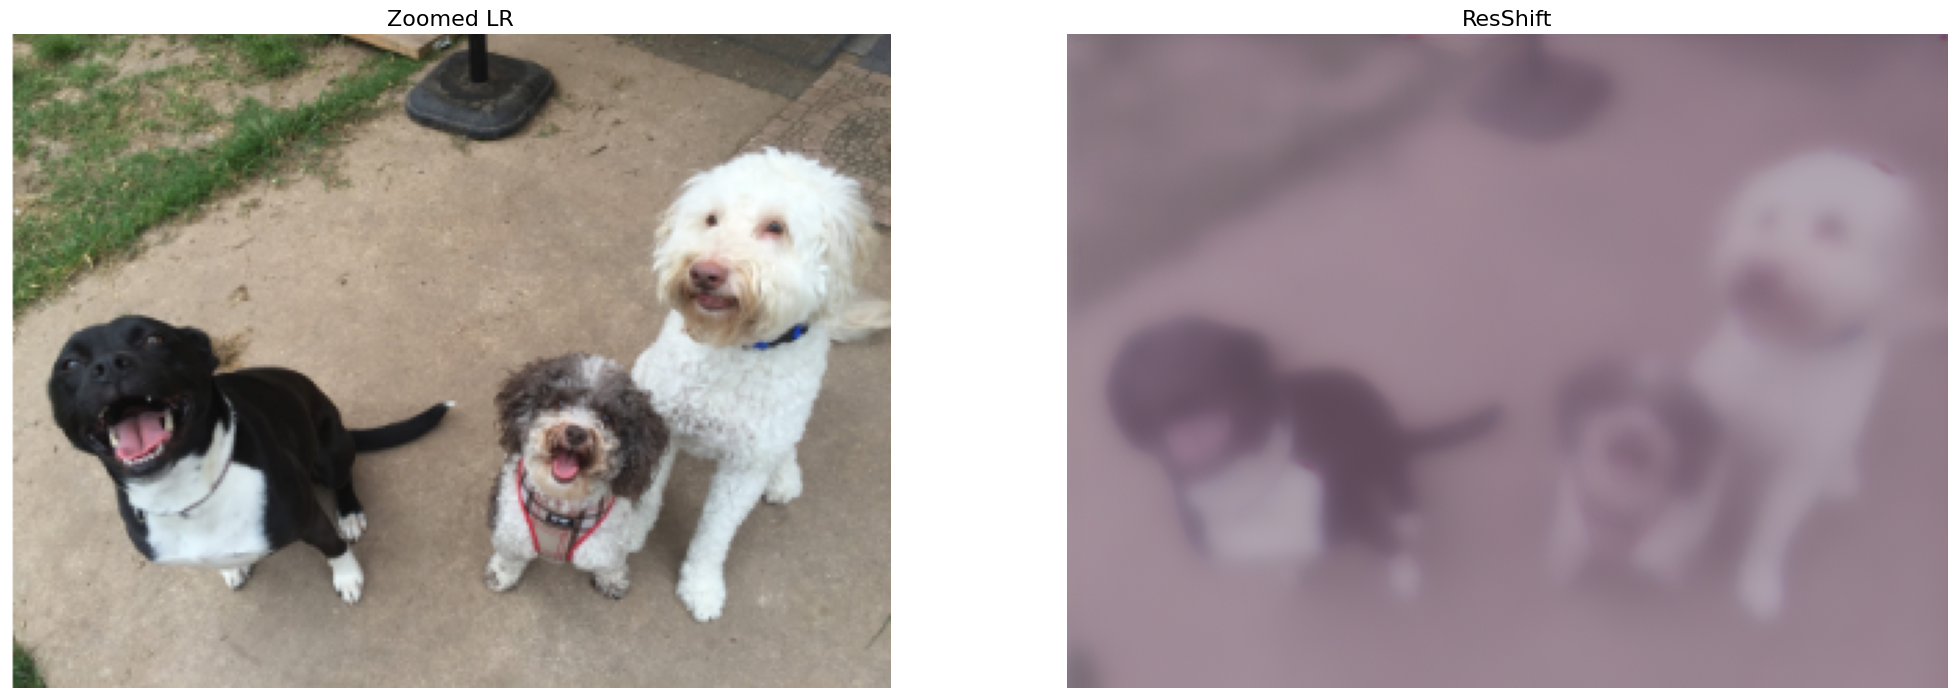

In [25]:
!python inference_resshift.py -i testdata/RealSet65/dog2.png -o results/ --task realsr --scale 4 --version v1

im_lq = imread("testdata/RealSet65/dog2.png")
im_hq = imread("results/dog2.png")
display(im_lq, im_hq)

In [24]:
!CUDA_VISIBLE_DEVICES=2 python main.py --cfg_path configs/realsr_swinunet_realesrgan256.yaml --save_dir results_train

trainer:
  target: trainer.TrainerDifIR
model:
  target: models.unet.UNetModelSwin
  ckpt_path: weights/resshift_realsrx4_s15_v2.pth
  params:
    image_size: 64
    in_channels: 3
    model_channels: 160
    out_channels: 3
    attention_resolutions:
    - 64
    - 32
    - 16
    - 8
    dropout: 0
    channel_mult:
    - 1
    - 2
    - 2
    - 4
    num_res_blocks:
    - 2
    - 2
    - 2
    - 2
    conv_resample: true
    dims: 2
    use_fp16: false
    num_head_channels: 32
    use_scale_shift_norm: true
    resblock_updown: false
    swin_depth: 2
    swin_embed_dim: 192
    window_size: 8
    mlp_ratio: 4
    cond_lq: true
    lq_size: 64
diffusion:
  target: models.script_util.create_gaussian_diffusion
  params:
    sf: 4
    schedule_name: exponential
    schedule_kwargs:
      power: 0.3
    etas_end: 0.99
    steps: 15
    min_noise_level: 0.04
    kappa: 2.0
    weighted_mse: false
    predict_type: xstart
    timestep_respacing: null
    scale_factor: 1.0
    normalize_i